# Ridge regression
This is a regression technique wich allows to deal with the multicollinearity of the features and try to reduce the overfitting of the data. 
minimize two elements, the RSS and the objective function 

In ridge regression two elements are optimized , the RSS and the objective function

$ \lVert y - Xw \rVert ^2_2 + \alpha \lVert w \rVert^2_2 $

It is a variation of the Linear regression with a tunning parameter alpha to control model complexity.
need to do a trade off between variance and bias
1. the inhability for the model to capture the true relationship is called bias. How well the model fits our data 
2. how well model does on a completely new dataset. 

use the hyper parameter called alpha , to add a bias , prevent the model from real, it will have better accurancy on the testing set, it means it will not overfit in the training set.  

## Libraries 

For this analysis, we will use a few libraries for managing and transform the database as well as to implement the ridge regression. First, let's download the libraries 

In [303]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from pandas import DataFrame

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn import decomposition

## Dataset analysis

Open the database, check the structure, show the head, take a look of its structure, the descriptive statistics and manage the columns.
Create the constants
The target value is the median_house_value which is predicted based on the features of different houses.

The mean_squared_error function computes mean square error, a risk metric corresponding to the expected value of the squared (quadratic) error or loss.

In [304]:
RMS = 'neg_mean_squared_error'


Valori di ɑ usati

In [305]:
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.25, 0.26, 0.27, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.5, 2]

we shuffle data to reduce the error, we randomize in order to handle the outliers and give a normal distribution to the whole dataset. 
Create the constants

In [306]:
shuffleDataSet = True

column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [307]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

In [308]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [309]:
data_frame.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [310]:
data_frame.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.70,39.36,37.0,2330.0,495.0,1505.0,470.0,2.0474,56000.0,INLAND
1,-121.01,37.69,20.0,3275.0,760.0,1538.0,705.0,2.4800,135600.0,INLAND
2,-117.25,32.79,25.0,1627.0,375.0,735.0,378.0,3.6429,317100.0,NEAR OCEAN
3,-121.37,38.57,22.0,4899.0,847.0,1701.0,826.0,5.2449,387000.0,INLAND
4,-119.03,34.22,24.0,3421.0,656.0,2220.0,645.0,4.7831,214200.0,<1H OCEAN


Here is the distribution of the values of the target variable "median_house_value".
It looks like a normal distribution with a group of outliers on the hihest value of the house.

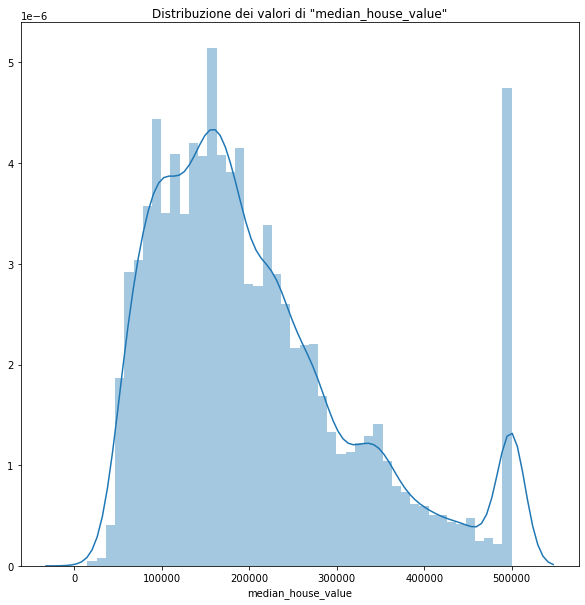

In [311]:
plt.figure(figsize=(10, 10))
plt.title('Distribuzione dei valori di "median_house_value"')
seaborn.distplot(data_frame[column_to_predict])
plt.show()

## Data pre-processing 
###  Missing values

The dataset contains missing values which are handeled by replacing the value with the mean value of the column. This procedure is necessary to avoid errors in the execution.

In [312]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)


### Categorical feature
Categorical values cannot be treated as such for the statistical analysis, therefore they must be transormed in numbers.
We generate columns for each element of the categorical feature. 

In [313]:
columns_categories = pandas.DataFrame()

for c in categories_columns:
    column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')
    columns_categories = pandas.concat((columns_categories, column), axis=1)

columns_categories


,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,0,1
3,0,1,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
20635,1,0,0,0,0
20636,0,0,0,0,1
20637,0,1,0,0,0
20638,1,0,0,0,0


Then delete the categorical column and add a column for each element of the deleted categorical column

In [314]:
data_frame.drop(columns=categories_columns, inplace=True)
data_frame = pandas.concat([data_frame, columns_categories], axis=1)

### Correlation of the dataset
Explore the Peasrson's coefficient of correlation and build a simmetric correlation matrix between the features. This procedure is helpeful to eventually reduce the dimension of the dataset. 

Equazioni esempio:
$$ \hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j}  $$

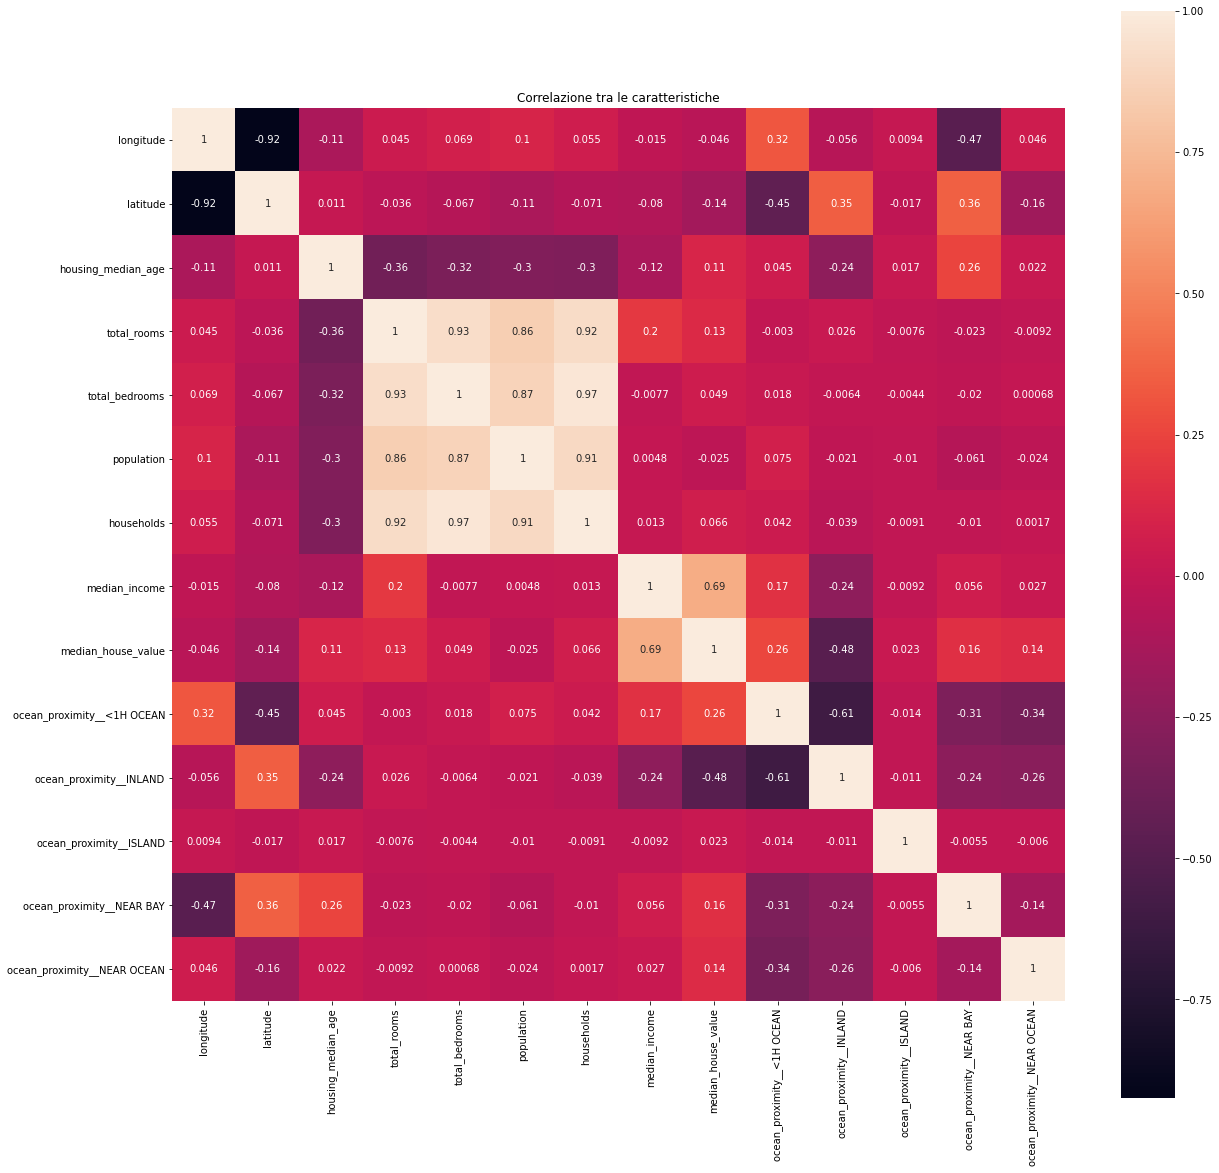

In [315]:
corr = data_frame.corr()
plt.figure(figsize=(20, 20))
plt.title('Correlazione tra le caratteristiche')
seaborn.heatmap(corr, square=True, annot=True)
plt.show()

Pearson's coefficient is determined by :


$$ r_{i,j} = \frac{\sum_{t=1}^m (x_{i,t}-\mu_i)(x_{j,t}-\mu_j)}{\sqrt{\sum_{t=1}^m (x_{i,t}-\mu_i)^2}\sqrt{\sum_{t=1}^m (x_{j,t}-\mu_j)^2}} $$

The coefficient is in between -1 and +1, when it is close to |1| then there is a correlation (positive or negative) otherwise if the coefficient is close to 0 there isn't any correlation. If some features are linearly correlated they are not useful, because we can explain one feature through the correlated one.

In [316]:
correlated_features = corr[((corr > 0.75) | (corr < -0.75)) & (corr != 1.0)].dropna(axis='index', how='all')
correlated_features

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
longitude,NaN,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,-0.924664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_rooms,NaN,NaN,NaN,NaN,0.927253,0.857126,0.918484,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bedrooms,NaN,NaN,NaN,0.927253,NaN,0.873910,0.974725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
population,NaN,NaN,NaN,0.857126,0.873910,NaN,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN
households,NaN,NaN,NaN,0.918484,0.974725,0.907222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see the pairs of the most correlated features are 
( households - total_bedrooms)
(population - housegìholds)
(total_rooms - total_bedrooms)
(total_bedroom - households)

Delete the correlated features

1. population 
2. total_rooms

In [317]:
columns_to_remove = ['population', 'total_rooms', column_to_predict]
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)

X = data_frame.drop(columns=columns_to_remove)
y = data_frame[column_to_predict]

Quindi la nostra attuale X è la seguente:

In [318]:
X

,longitude,latitude,housing_median_age,total_bedrooms,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-121.70,39.36,37.0,495.0,470.0,2.0474,0,1,0,0,0
1,-121.01,37.69,20.0,760.0,705.0,2.4800,0,1,0,0,0
2,-117.25,32.79,25.0,375.0,378.0,3.6429,0,0,0,0,1
3,-121.37,38.57,22.0,847.0,826.0,5.2449,0,1,0,0,0
4,-119.03,34.22,24.0,656.0,645.0,4.7831,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-118.38,33.88,27.0,606.0,564.0,5.5771,1,0,0,0,0
20636,-118.29,33.73,43.0,519.0,486.0,2.5759,0,0,0,0,1
20637,-121.29,38.63,24.0,527.0,487.0,3.3182,0,1,0,0,0
20638,-118.17,34.06,44.0,461.0,452.0,2.5033,1,0,0,0,0


Quindi la nostra attuale y è la seguente:

In [319]:
y


0         56000.0
1        135600.0
2        317100.0
3        387000.0
4        214200.0
           ...   
20635    345500.0
20636    225000.0
20637    213000.0
20638    131900.0
20639    152500.0
Name: median_house_value, Length: 20640, dtype: float64

## Learning algorithm
Before starting to learn the algorithm, the dataset must be splitted in  subsets in order to preserve some data for the validation of the method.

### Train & Test
Train 80%, Test 20%

In [320]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=shuffleDataSet)

### Elaborazione per range di ɑ
The coefficient R² is defined as $ 1 - {u \over v} $, where u is the residual sum of squares $ \sum (y - y')^2 $ and v is the total sum of squares $ \sum (y - \bar{y})^2 $.

The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

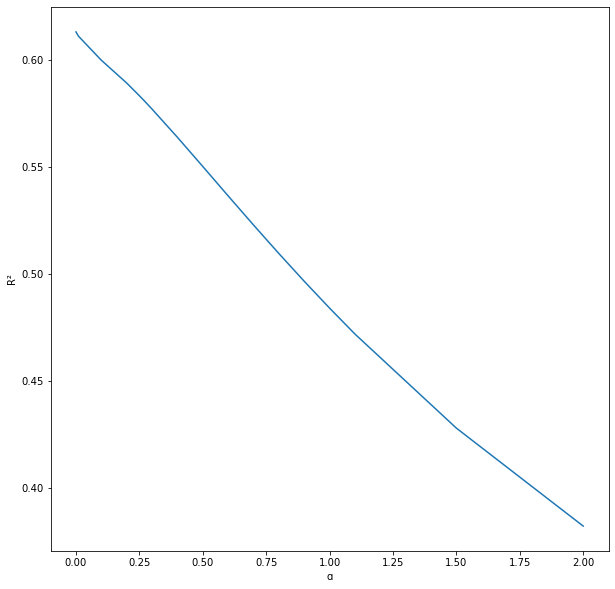

In [321]:
scores = []

for ɑ in alphas:
    learner = Ridge(alpha=ɑ, normalize=True)
    learner.fit(x_train, y_train)

    score = learner.score(x_test, y_test)
    scores.append(score)

plt.figure(figsize=(10, 10))

plt.plot(alphas, scores)

plt.xlabel("ɑ")
plt.ylabel("R²")

plt.show()

### Cross-validated risk estimate
Cross Validation is is a method that allows to perform selection and  validation of the learning algorithm. 
set aside a portion of the data for the test set and perform multiple interations on the training data, splitted in k-folds and validate the hyperparameter to one fold per time . Then compare to the test data. 
Method for comparing is the root mean squared error. 
normalize to get values normalized 
Use the 5-fold cross validation 

In [322]:
# sostituire con il nostro medoto
learner = Ridge(alpha=0.01, normalize=True)
scores = cross_val_score(learner, X, y, cv=5, scoring=RMS)
print(f'Cross-validated risk estimate: {-scores.mean()}')

Cross-validated risk estimate: 5115190706.692932


### Learning curve
For tuning the hyper-parameters of an estimator, in our case alpha of the ridge regression, use the grid search. 
random split into training and test sets  

In [323]:
# records da 1 a 2851, step 550 = 7 punti
sizes = range(1, 3851, 550)

# 5 fold di C.V.
train_size, train_score, val_score = learning_curve(learner, X, y, train_sizes=sizes, cv=5, scoring=RMS)

### Standard deviation
Standard deviation is the most important tool for dispersion measurement in a distribution. Technically, the standard deviation is the square root of the arithmetic mean of the squares of deviations of observations from their mean value.
### Arithmetic Mean
Mean is the measure of central tendency most commonly used. Mean is equal to the sum of all the values of a collection of data divided by the number of values in the data.

In [324]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

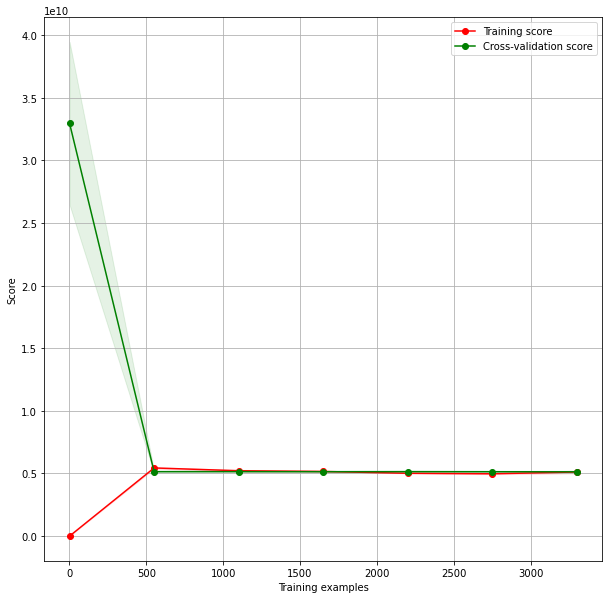

In [325]:
plt.figure(figsize=(10, 10))
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

## Principal Component Analysis
PCA is a method used to reduce number of variables in your data by extracting important one from a large pool. It reduces the dimension of your data with the aim of retaining as much information as possible. In other words, this method combines highly correlated variables together to form a smaller number of an artificial set of variables which is called “principal components” that account for most variance in the data.

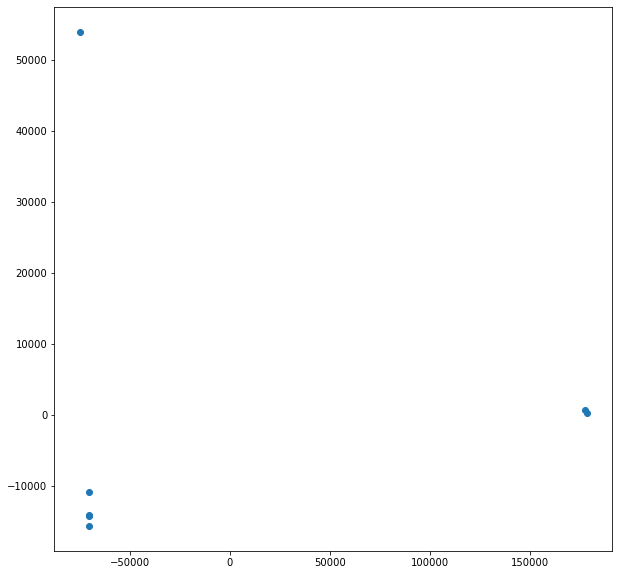

In [326]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=s, shuffle=shuffleDataSet)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

plt.figure(figsize=(10, 10))
plt.scatter(coef_pca[:, 0], coef_pca[:, 1])


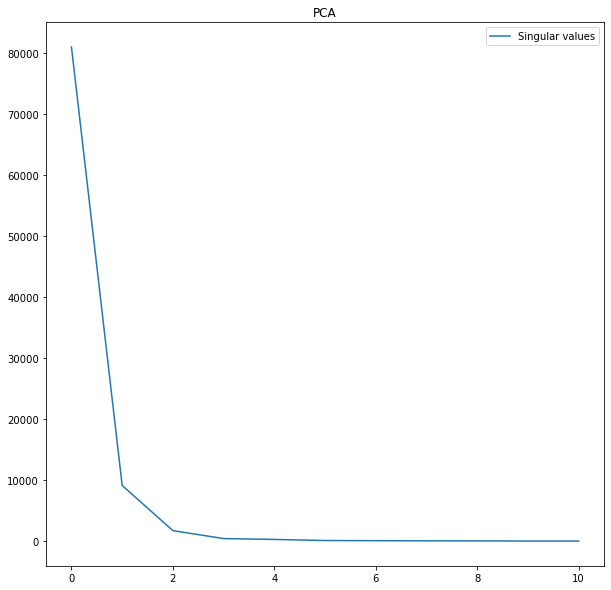

In [327]:
pca = decomposition.PCA(n_components=X.shape[1])
pca.fit(X)

plt.figure(figsize=(10, 10))
plt.title('PCA')
plt.plot(pca.singular_values_, label='Singular values')
plt.legend()
plt.show()

We project all the datapoints on the principal components. Then we check the learning curve again.

In [328]:
pca = decomposition.PCA(n_components=4)
pca.fit(X)
X_pca = pca.transform(X)

In [329]:
X

,longitude,latitude,housing_median_age,total_bedrooms,households,median_income,ocean_proximity__<1H OCEAN,ocean_proximity__INLAND,ocean_proximity__ISLAND,ocean_proximity__NEAR BAY,ocean_proximity__NEAR OCEAN
0,-121.70,39.36,37.0,495.0,470.0,2.0474,0,1,0,0,0
1,-121.01,37.69,20.0,760.0,705.0,2.4800,0,1,0,0,0
2,-117.25,32.79,25.0,375.0,378.0,3.6429,0,0,0,0,1
3,-121.37,38.57,22.0,847.0,826.0,5.2449,0,1,0,0,0
4,-119.03,34.22,24.0,656.0,645.0,4.7831,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
20635,-118.38,33.88,27.0,606.0,564.0,5.5771,1,0,0,0,0
20636,-118.29,33.73,43.0,519.0,486.0,2.5759,0,0,0,0,1
20637,-121.29,38.63,24.0,527.0,487.0,3.3182,0,1,0,0,0
20638,-118.17,34.06,44.0,461.0,452.0,2.5033,1,0,0,0,0


In [330]:
X_pca.shape

(20640, 4)

In [331]:
DataFrame(X_pca)

,0,1,2,3
0,-51.648525,7.105019,7.955398,4.191535
1,302.623118,2.407378,-6.509629,2.757974
2,-202.232309,19.620778,-5.354606,-3.658033
3,448.384217,33.413622,-3.978002,3.535849
4,185.294172,28.058390,-3.755304,-1.405177
...,...,...,...,...
20635,93.782992,1.825696,-1.056814,-2.167930
20636,-23.169166,2.877052,14.166330,-2.348583
20637,-16.447638,-2.028313,-4.698963,3.473280
20638,-88.957156,16.763275,14.511546,-2.279142


In [332]:
# 5 fold di C.V.
train_size, train_score, val_score = learning_curve(learner, X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [333]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

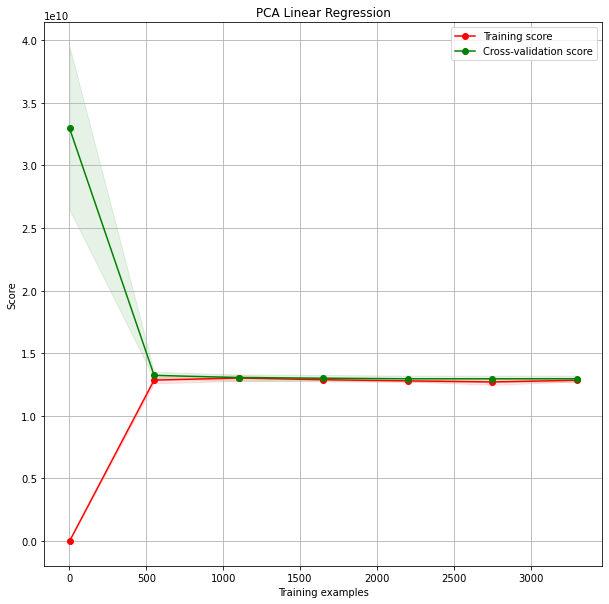

In [334]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression')
plt.grid()

plt.fill_between(sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, color="r", alpha=0.1)
plt.fill_between(sizes, val_score_mean - val_score_std, val_score_mean + val_score_std, color="g", alpha=0.1)

plt.plot(sizes, train_score_mean, 'o-', color="r", label="Training score")
plt.plot(sizes, val_score_mean, 'o-', color="g", label="Cross-validation score")

plt.legend()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.show()

In [335]:
coef_list = []

for s in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=s, shuffle=shuffleDataSet)
    learner.fit(X_train, y_train)
    coef_list.append(learner.coef_)

coef_matrix = numpy.array(coef_list)

In [336]:
pca = decomposition.PCA(n_components=2)
pca.fit(coef_matrix)
coef_pca = pca.transform(coef_matrix)

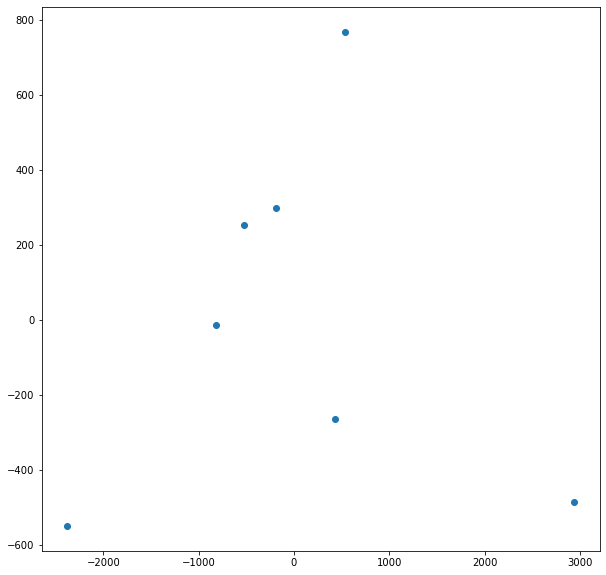

In [337]:
plt.figure(figsize=(10, 10))
plt.scatter(coef_pca[:,0], coef_pca[:,1])
plt.show()

## Parte Solo Ridge Regression

In [338]:
alpha_vals = numpy.linspace(0.01, 2.0, 20)
train_score, val_score = validation_curve(Ridge(alpha=0.01, normalize=True), X, y, 'alpha', alpha_vals, cv=5, scoring=RMS)

In [339]:
train_score_mean = -numpy.mean(train_score, axis=1)
train_score_std = numpy.std(train_score, axis=1)
val_score_mean = -numpy.mean(val_score, axis=1)
val_score_std = numpy.std(val_score, axis=1)

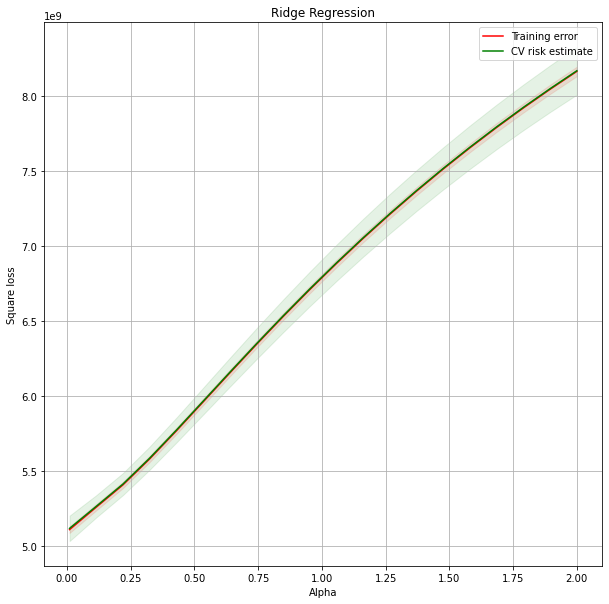

In [340]:
plt.figure(figsize=(10, 10))
plt.title('Ridge Regression')
plt.grid()

plt.fill_between(alpha_vals, train_score_mean - train_score_std, train_score_mean + train_score_std, alpha=0.1, color="r")
plt.fill_between(alpha_vals, val_score_mean - val_score_std, val_score_mean + val_score_std, alpha=0.1, color="g")

plt.plot(alpha_vals, train_score_mean, color="r", label="Training error")
plt.plot(alpha_vals, val_score_mean, color="g", label="CV risk estimate")

plt.xlabel('Alpha')
plt.ylabel('Square loss')
plt.legend()
plt.show()

In [341]:
l_train_size, l_train_score, l_val_score = learning_curve(LinearRegression(normalize=True), X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)
r_train_size, r_train_score, r_val_score = learning_curve(Ridge(alpha=0.01, normalize=True), X_pca, y, train_sizes=sizes, cv=5, scoring=RMS)

In [342]:
l_val_score_mean = -numpy.mean(l_val_score, axis=1)
l_val_score_std = numpy.std(l_val_score, axis=1)
r_val_score_mean = -numpy.mean(r_val_score, axis=1)
r_val_score_std = numpy.std(r_val_score, axis=1)

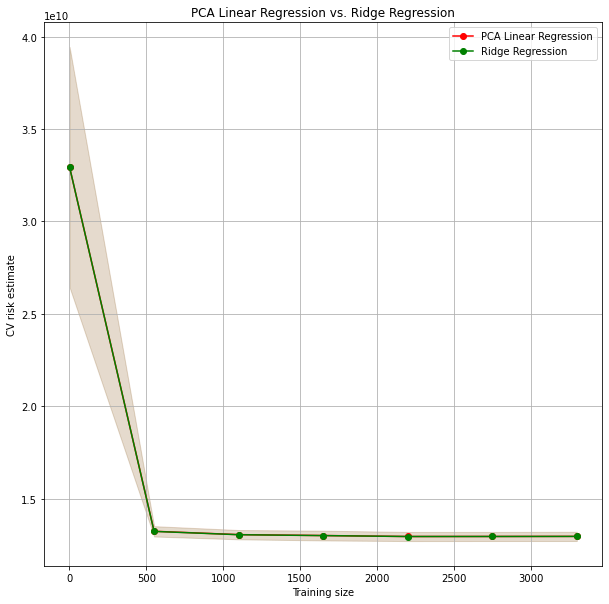

In [343]:
plt.figure(figsize=(10, 10))
plt.title('PCA Linear Regression vs. Ridge Regression')
plt.grid()

plt.fill_between(sizes, l_val_score_mean - l_val_score_std, l_val_score_mean + l_val_score_std, alpha=0.1, color="r")
plt.fill_between(sizes, r_val_score_mean - r_val_score_std, r_val_score_mean + r_val_score_std, alpha=0.1, color="g")

plt.plot(sizes, l_val_score_mean, 'o-', color="r", label="PCA Linear Regression")
plt.plot(sizes, r_val_score_mean, 'o-', color="g", label="Ridge Regression")

plt.xlabel('Training size')
plt.ylabel('CV risk estimate')
plt.legend()
plt.show()